# Quantum Distance Based Classifier

#### Follows the implementation of the Quantum Distance Based Classifier by Schuld, Fingerhuth and Petruccione
#### For more details: https://arxiv.org/abs/1703.10793

In [1]:
import qiskit
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, Aer
from qiskit.extensions import Initialize, UnitaryGate
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city
from qiskit_textbook.tools import random_state, array_to_latex
from utility import qdrawer
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools

## Quantum Circuit

In [2]:
class QDistanceBasedClassifier:
    
####################################################################
    def get_circuit(self):
        return self.qc

####################################################################
    def _qr_ccry(self, theta, a, b, t):
        self.qc.ccx(a,b,t)

        self.qc.cx(b,t)    
        self.qc.ry(theta, t)

        self.qc.cx(b,t)    
        self.qc.ry(-theta, t)

        self.qc.ccx(a,b,t)

        self.qc.cx(b,t)    
        self.qc.ry(-theta, t)

        self.qc.cx(b,t)    
        self.qc.ry(theta, t)
        
####################################################################
        
    def _step_A(self, a, b):
        '''Uniform superpos of ancilla and index qubit'''
        self.qc.h(a)
        self.qc.h(b)

####################################################################

    def _step_B(self, theta, a, c):
        '''Loading test vector  '''
        #qc.cry(theta, a, c)
        self.qc.cx(a, c)
        self.qc.u(-theta, 0, 0, c)
        self.qc.cx(a, c)
        self.qc.u(theta, 0, 0, c)

        self.qc.barrier()
        self.qc.x(a)
        self.qc.barrier()
        
####################################################################

    def _step_C(self, a, b, c):
        '''Loading first training vector'''
        self.qc.ccx(a,b,c)
        self.qc.x(b)
        self.qc.barrier()

####################################################################
        
    def _step_D(self, theta, a, b, c, d):
        '''Load second training vector'''
        self._qr_ccry(theta, a, b, c)
        self.qc.barrier()
        self.qc.cx(b, d)
        self.qc.barrier()
        
####################################################################

    def _step_F(self, a):
        '''Compute distance'''
        self.qc.h(a)
        self.qc.barrier()
        
####################################################################

    def step_measure(self):
        '''Measurements'''
        self.qc.measure(self.aqr, self.c_areg)
        self.qc.measure(self.cqr, self.c_creg)
        
####################################################################

    def _init_qc(self):
        aqr = QuantumRegister(1, name="ancilla ")
        mqr = QuantumRegister(1, name="index qregister ") #Just one since we have only two training inputs
        iqr = QuantumRegister(1, name="data register ")
        cqr = QuantumRegister(1, name="classes ")

        c_areg = ClassicalRegister(1, name="classical ancilla ")
        c_creg = ClassicalRegister(1, name="classical classes ")
        
        qc = QuantumCircuit(aqr, mqr, iqr, cqr, c_areg, c_creg)
        return qc, aqr, mqr, iqr, cqr, c_areg, c_creg
    
####################################################################

    def __init__(self, theta_tr_1, theta_test): #Not loading thetha_tr_0
        self.qc, self.aqr, self.mqr, self.iqr, self.cqr, self.c_areg, self.c_creg = self._init_qc()
        
        #Uniform superpos of ancilla and index qubits
        self._step_A(self.aqr, self.mqr)

        #Loading test vector
        self._step_B(theta_test, self.aqr, self.iqr)

        #Loading first training vector
        self._step_C(self.aqr, self.mqr, self.iqr)

        #Load second training vector
        self._step_D(theta_tr_1, self.aqr, self.mqr, self.iqr, self.cqr)

        #compute distance
        self._step_F(self.aqr)
        
        self.step_measure()     

####################################################################

# MAIN

### Load Circuit

In [3]:
#Follows the paper's inputs

test_1 = [-0.549, 0.836]   
tr_0 = [0,1] 
tr_1 = [0.789, 0.615]


#Computing the rotation angle
theta_test = np.arctan2(test_1[1], test_1[0])
theta_tr_1 = np.arctan2(tr_1[1], tr_1[0])/2
#using arcatan2 --> Obtain the correct quadrans. Otherwise, with arctan(y/x) you cannot get the correct quadrant
#ex: -1.52 can be obtained from (-y/x) and (y/-x)


q_distance_based_classifier = QDistanceBasedClassifier(theta_tr_1, theta_test)

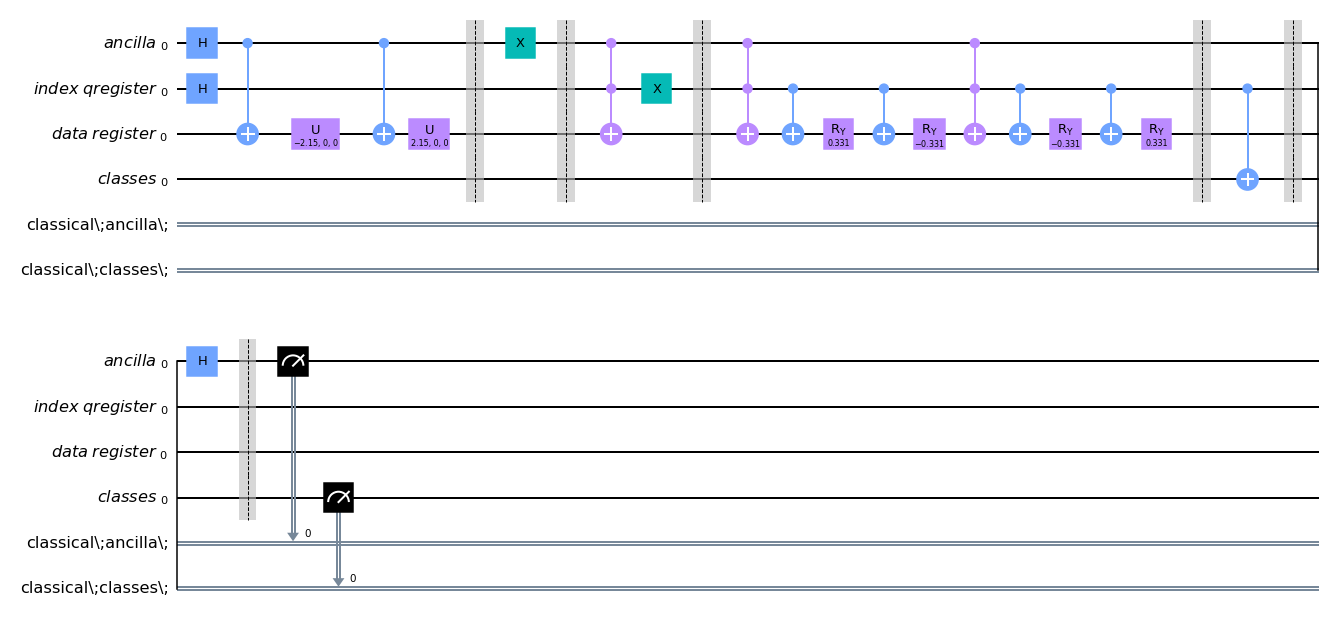

In [4]:
q_distance_based_circuit =  q_distance_based_classifier.get_circuit()
q_distance_based_circuit.draw()

## Plotting Dataset (Unitary circle)

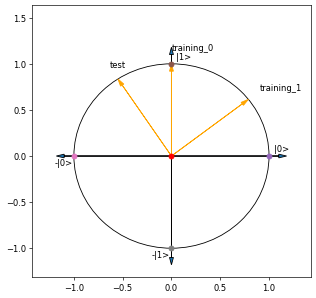

In [5]:
qdrawer.draw_qubit()
qdrawer.draw_quantum_state(test_1[0],test_1[1],"test", color='orange')
qdrawer.draw_quantum_state(tr_1[0],tr_1[1],"training_1", color='orange')
qdrawer.draw_quantum_state(0, 1,"training_0", color='orange')

# Simulation

In [6]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(q_distance_based_circuit, simulator, shots=4096)
result = job.result()
counts = result.get_counts(q_distance_based_circuit)
goodCounts = {k: counts[k] for k in counts.keys() & {'0 0', '1 0'}}

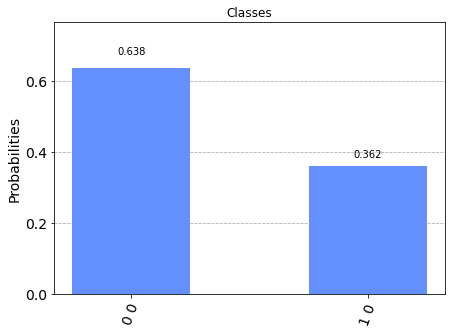

In [7]:
plot_histogram(goodCounts, title="Classes")

### On x axis, the highest bit indicates the output class. So:
#### 00 --> test vector belongs to class 0
#### 10 --> test vector belongs to class 1